In [1]:
import numpy as np
from sanchez_ansatz import SanchezAnsatz
from qiskit_aer import Aer
from experiments import get_state
from experiments.densities import get_probability_freqs
from experiments import ExperimentModule
from qiskit import transpile
from qiskit_algorithms.optimizers import SPSA, COBYLA
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
num_qubits = 8
state_type = "normal"
state_params = { "loc": 0.5 , "scale": 0.6, "x_points": np.array([0., 1.])}

#### Original Method

In [3]:

x_points = np.linspace(state_params["x_points"][0], state_params["x_points"][1], 2**num_qubits)

target_state = get_probability_freqs(x_points, num_qubits=num_qubits, density=state_type, density_params={ "loc": state_params["loc"], "scale": state_params["loc"]})
#state  = get_state(num_qubits=num_qubits, state_type=state_type, state_params=state_params)
#probs = norm.pdf(x_points, loc=state_params["loc"], scale=state_params["scale"])
#target_state = probs/np.linalg.norm(probs)

computed_eta = 2/state_params["scale"]**2

sanchez_ansatz = SanchezAnsatz(target_state, eps=0.05) #eta=computed_eta
init_params = sanchez_ansatz.init_params

t_sa = transpile(sanchez_ansatz, basis_gates=["cx", "u"])

em = ExperimentModule(
    t_sa,
    SPSA(maxiter=3000),
    target_state=target_state,
    init_params=init_params,
)
result = em.minimize()

In [4]:
pt_sa = t_sa.assign_parameters(result.x)
sv_sim = Aer.get_backend("statevector_simulator")
job = sv_sim.run(pt_sa)
job_result = job.result()
res_statevector = job_result.get_statevector().data

fid = np.abs(res_statevector.conj() @ target_state)**2

print("Fidelity: ", fid)
print("Fidloss: ", 1 - fid)
print("SanchezAnsatz k0: ", sanchez_ansatz.k0)
print("Computed eta: ", computed_eta)

Fidelity:  0.9986687874577501
Fidloss:  0.0013312125422498822
SanchezAnsatz k0:  3
Computed eta:  5.555555555555555


In [5]:
print(res_statevector[:5])
print(target_state[:5])

[0.04922283+0.j 0.04922259+0.j 0.04922266+0.j 0.04922243+0.j
 0.04922264+0.j]
[0.0439092  0.04425358 0.04459792 0.04494217 0.04528629]


/home/ismael/anaconda3/envs/sanches-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


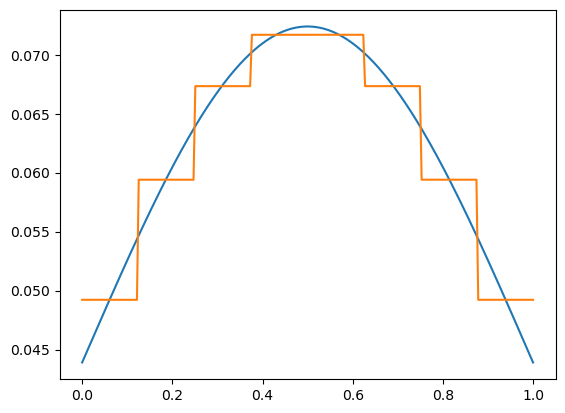

In [6]:
plt.plot(x_points, target_state)
plt.plot(x_points, res_statevector)
plt.show()

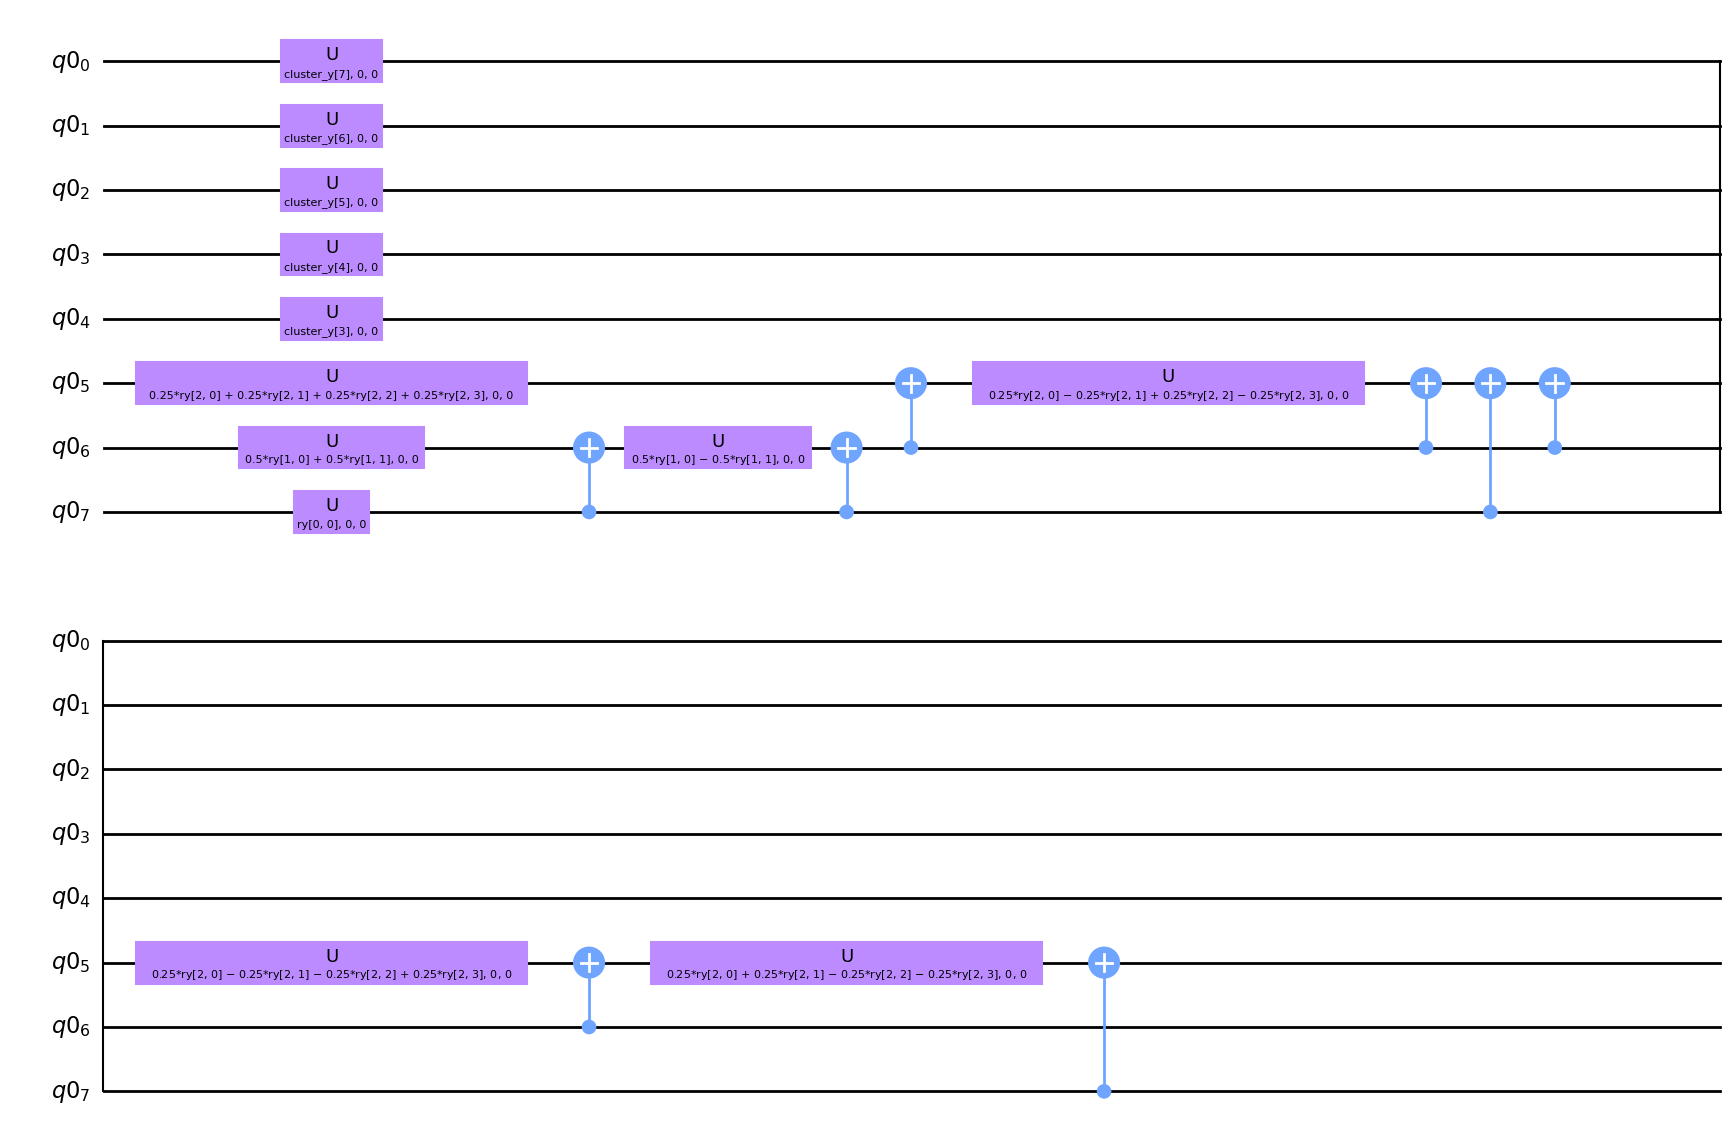

In [7]:
t_sa.draw("mpl")

#### Modified Method

In [8]:

x_points = np.linspace(state_params["x_points"][0], state_params["x_points"][1], 2**num_qubits)

freqs = get_probability_freqs(x_points, num_qubits=num_qubits, density=state_type, density_params={ "loc": state_params["loc"], "scale": state_params["loc"]})
#state  = get_state(num_qubits=num_qubits, state_type=state_type, state_params=state_params)
probs = norm.pdf(x_points, loc=state_params["loc"], scale=state_params["scale"])
target_state = probs/np.linalg.norm(probs)

#computed_eta = 2/state_params["scale"]**2

sanchez_ansatz = SanchezAnsatz(target_state, eps=0.05, build_modified=True) #eta=computed_eta,
init_params = sanchez_ansatz.init_params

t_sa = transpile(sanchez_ansatz, basis_gates=["cx", "u"])

em = ExperimentModule(
    t_sa,
    COBYLA(maxiter=3000),
    target_state=target_state,
    init_params=init_params,
)
result = em.minimize()

In [9]:
pt_sa = t_sa.assign_parameters(result.x)
sv_sim = Aer.get_backend("statevector_simulator")
job = sv_sim.run(pt_sa)
job_result = job.result()
res_statevector = job_result.get_statevector().data

fid = np.abs(res_statevector.conj() @ target_state)**2

print("Fidelity: ", fid)
print("Fidloss: ", 1 - fid)
print("SanchezAnsatz k0: ", sanchez_ansatz.k0)
print("Computed eta: ", computed_eta)

Fidelity:  0.9993038361065528
Fidloss:  0.000696163893447177
SanchezAnsatz k0:  3
Computed eta:  5.555555555555555


In [10]:
print(res_statevector[:5])
print(target_state[:5])

[0.05303889+0.j 0.05304356+0.j 0.05304073+0.j 0.05304213+0.j
 0.05312864+0.j]
[0.04911771 0.04938491 0.04965144 0.04991728 0.0501824 ]


/home/ismael/anaconda3/envs/sanches-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


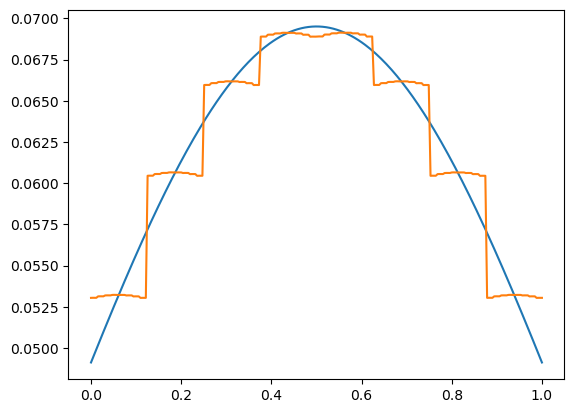

In [11]:
plt.plot(x_points, target_state)
plt.plot(x_points, res_statevector)
plt.show()

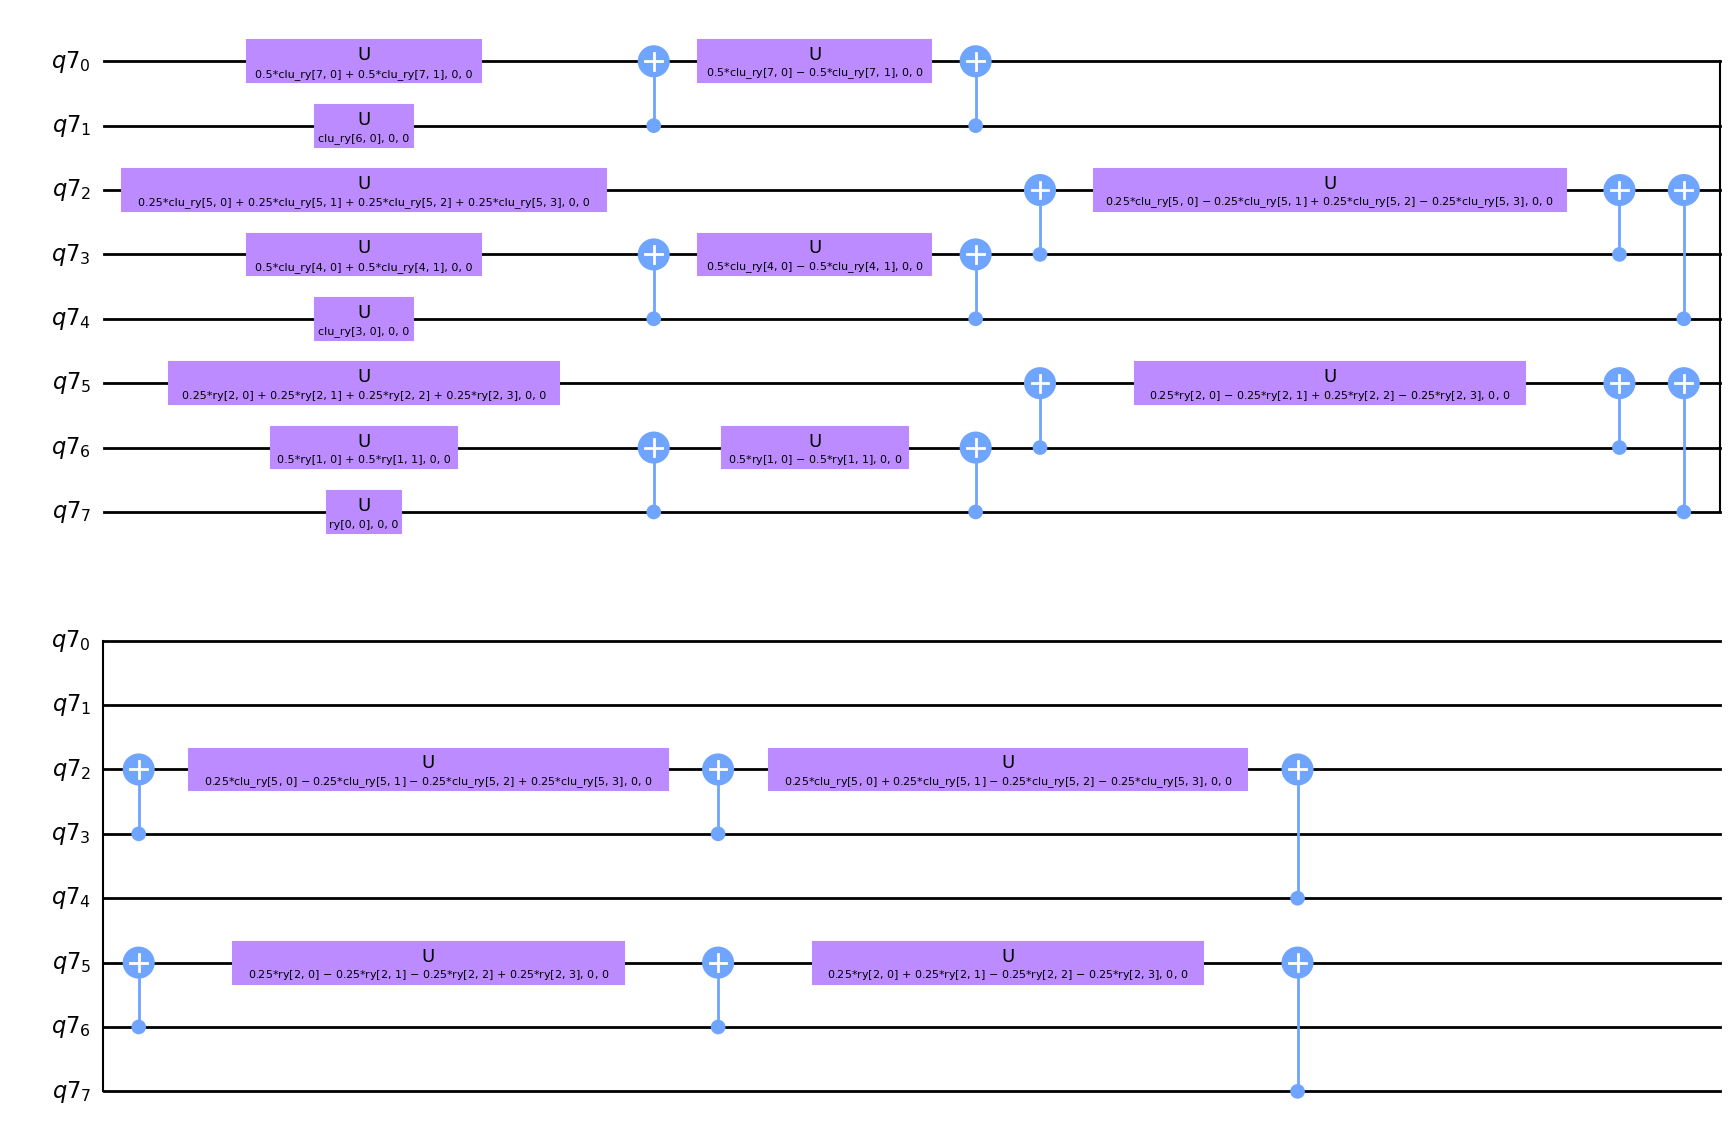

In [12]:
t_sa.draw("mpl")